# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
import json
warnings.filterwarnings('ignore')
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Cleaning portfolio


In [7]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [8]:
portfolio.dtypes

reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object

In [9]:
# Creating dummy variables for channels and offer_id

dummy_variables_channels = pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0)
dummy_variables_offer_type = pd.get_dummies(portfolio['offer_type'].apply(pd.Series).stack()).sum(level=0)

# Concatenate dummy variables with the original DataFrame
portfolio = pd.concat([portfolio, dummy_variables_channels], axis=1)
portfolio = pd.concat([portfolio, dummy_variables_offer_type], axis=1)


In [10]:
portfolio

,reward,channels,difficulty,duration,offer_type,id,email,mobile,social,web,bogo,discount,informational
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


In [11]:
# Dropping channels and offer_type
portfolio.drop(['channels','offer_type'],axis=1,inplace=True)

In [12]:
# Renaming the column 'id' in the portfolio dataframe to 'offer_id'
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [13]:
portfolio

,reward,difficulty,duration,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


In [14]:
portfolio = portfolio[['offer_id','reward', 'difficulty', 'duration', 'email', 'mobile',
       'social', 'web', 'bogo', 'discount', 'informational']]

In [15]:
portfolio

,offer_id,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,0,4,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,1,0,0,1,0,1,0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,1,1,1,1,0,1,0
6,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,1,1,1,1,0,1,0
7,5a8bc65990b245e5a138643cd4eb9837,0,0,3,1,1,1,0,0,0,1
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,1,1,1,1,0,0
9,2906b810c7d4411798c6938adc9daaa5,2,10,7,1,1,0,1,0,1,0


## Cleaning profile

In [16]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [17]:
# Checking unique values in 'age' column of the profile dataframe
profile['age'].unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99], dtype=int64)

In [18]:
# Viewing rows where 'age' is equal to 118
profile[profile['age'] == 118]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


Age 118 has no entrties for income or gender. Which means the entry could be a typo.

Hence, droppping it

In [19]:
# Removing rows where 'age' is equal to 118 from the profile dataframe
profile = profile[profile['age'] != 118]

In [20]:
profile

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


For Gender column we are assigning the values 

1 for Male

0 for Female

In [21]:
# Replacing 'M' with 1 and all other values with 0 in the 'gender' column of the profile dataframe
profile['gender'] = profile['gender'].apply(lambda x: 1 if x == 'M' else 0 )

In [22]:
profile

,gender,age,id,became_member_on,income
1,0,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,0,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,1,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,1,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,1,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0
...,...,...,...,...,...
16995,0,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,1,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,1,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,0,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [23]:
profile.gender.unique()

array([0, 1], dtype=int64)

In [24]:
# Converting the 'became_member_on' column to datetime format
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [25]:
# Renaming the column 'id' in the profile dataframe to 'customer_id'
profile.rename(columns={"id":"customer_id"},inplace=True)

In [26]:
profile

,gender,age,customer_id,became_member_on,income
1,0,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,0,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,1,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,1,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,1,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0
...,...,...,...,...,...
16995,0,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0
16996,1,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0
16997,1,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0
16998,0,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0


In [27]:
profile.columns

Index(['gender', 'age', 'customer_id', 'became_member_on', 'income'], dtype='object')

In [28]:
# Rearranging columns in the profile dataframe
profile = profile[['customer_id','gender', 'age', 'became_member_on', 'income']]

In [29]:
profile

,customer_id,gender,age,became_member_on,income
1,0610b486422d4921ae7d2bf64640c50b,0,55,2017-07-15,112000.0
3,78afa995795e4d85b5d9ceeca43f5fef,0,75,2017-05-09,100000.0
5,e2127556f4f64592b11af22de27a7932,1,68,2018-04-26,70000.0
8,389bc3fa690240e798340f5a15918d5c,1,65,2018-02-09,53000.0
12,2eeac8d8feae4a8cad5a6af0499a211d,1,58,2017-11-11,51000.0
...,...,...,...,...,...
16995,6d5f3a774f3d4714ab0c092238f3a1d7,0,45,2018-06-04,54000.0
16996,2cb4f97358b841b9a9773a7aa05a9d77,1,61,2018-07-13,72000.0
16997,01d26f638c274aa0b965d24cefe3183f,1,49,2017-01-26,73000.0
16998,9dc1421481194dcd9400aec7c9ae6366,0,83,2016-03-07,50000.0


## Cleaning transcript

In [30]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [31]:
# Renaming the 'person' column in the transcript dataframe to 'customer_id'
transcript.rename(columns={"person":'customer_id'},inplace=True)

In [32]:
transcript

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [33]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [34]:
transcript['value']

0         {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2         {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4         {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
                                ...                       
306529                      {'amount': 1.5899999999999999}
306530                                    {'amount': 9.53}
306531                                    {'amount': 3.61}
306532                      {'amount': 3.5300000000000002}
306533                                    {'amount': 4.05}
Name: value, Length: 306534, dtype: object

In [35]:
# Define the functions for extraction
def create_amount_col(val):
    return val.get('amount')

def create_offer_id_col(val):
    return val.get('offer id') or val.get('offer_id')

# Vectorize operations using .map()
transcript['amount'] = transcript.value.map(create_amount_col)
transcript['offer_id'] = transcript.value.map(create_offer_id_col)


In [36]:
# drop value column
transcript.drop(columns=['value'], inplace=True)

# change amount column type to float
transcript.amount.astype('float')

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
306529    1.59
306530    9.53
306531    3.61
306532    3.53
306533    4.05
Name: amount, Length: 306534, dtype: float64

In [37]:
transcript

,customer_id,event,time,amount,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,None
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,None
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,None
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,None


Dropping transaction rows whose customer_id is not present in in profile table

In [38]:
profile

,customer_id,gender,age,became_member_on,income
1,0610b486422d4921ae7d2bf64640c50b,0,55,2017-07-15,112000.0
3,78afa995795e4d85b5d9ceeca43f5fef,0,75,2017-05-09,100000.0
5,e2127556f4f64592b11af22de27a7932,1,68,2018-04-26,70000.0
8,389bc3fa690240e798340f5a15918d5c,1,65,2018-02-09,53000.0
12,2eeac8d8feae4a8cad5a6af0499a211d,1,58,2017-11-11,51000.0
...,...,...,...,...,...
16995,6d5f3a774f3d4714ab0c092238f3a1d7,0,45,2018-06-04,54000.0
16996,2cb4f97358b841b9a9773a7aa05a9d77,1,61,2018-07-13,72000.0
16997,01d26f638c274aa0b965d24cefe3183f,1,49,2017-01-26,73000.0
16998,9dc1421481194dcd9400aec7c9ae6366,0,83,2016-03-07,50000.0


In [39]:
# Filtering the transcript dataframe to include only rows with 'customer_id' present in the profile dataframe
transcript = transcript[transcript['customer_id'].isin(profile['customer_id'])]

In [40]:
# Converting 'time' in transcript from hours to days by dividing by 24
transcript['time'] = transcript['time']/24

In [41]:
# Creating a new binary column 'received' where value is 1 if 'event' is 'offer received' and 0 otherwise
transcript['received'] = transcript.event.apply(lambda x: 1 if x == 'offer received' else 0)
# Creating a new binary column 'offer_completed' where value is 1 if 'event' is 'offer completed' and 0 otherwise
transcript['offer_completed'] = transcript.event.apply(lambda x: 1 if x == 'offer completed' else 0)
# Creating a new binary column 'transaction' where value is 1 if 'event' is 'transaction' and 0 otherwise
transcript['transaction'] = transcript.event.apply(lambda x: 1 if x == 'transaction' else 0)
# Creating a new binary column 'viewed' where value is 1 if 'event' is 'viewed' and 0 otherwise
transcript['viewed'] = transcript.event.apply(lambda x: 1 if x == 'viewed' else 0)

In [42]:
# Dropping the 'event' column from the transcript dataframe
transcript.drop('event',axis=1,inplace=True)

In [43]:
transcript

,customer_id,time,amount,offer_id,received,offer_completed,transaction,viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0.00,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0
2,e2127556f4f64592b11af22de27a7932,0.00,NaN,2906b810c7d4411798c6938adc9daaa5,1,0,0,0
5,389bc3fa690240e798340f5a15918d5c,0.00,NaN,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0.00,NaN,3f207df678b143eea3cee63160fa8bed,1,0,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,0.00,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,0
...,...,...,...,...,...,...,...,...
306527,24f56b5e1849462093931b164eb803b5,29.75,NaN,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0
306529,b3a1272bc9904337b331bf348c3e8c17,29.75,1.59,None,0,0,1,0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,29.75,9.53,None,0,0,1,0
306531,a00058cf10334a308c68e7631c529907,29.75,3.61,None,0,0,1,0


# Exploratory Data Analysis

# Transcript

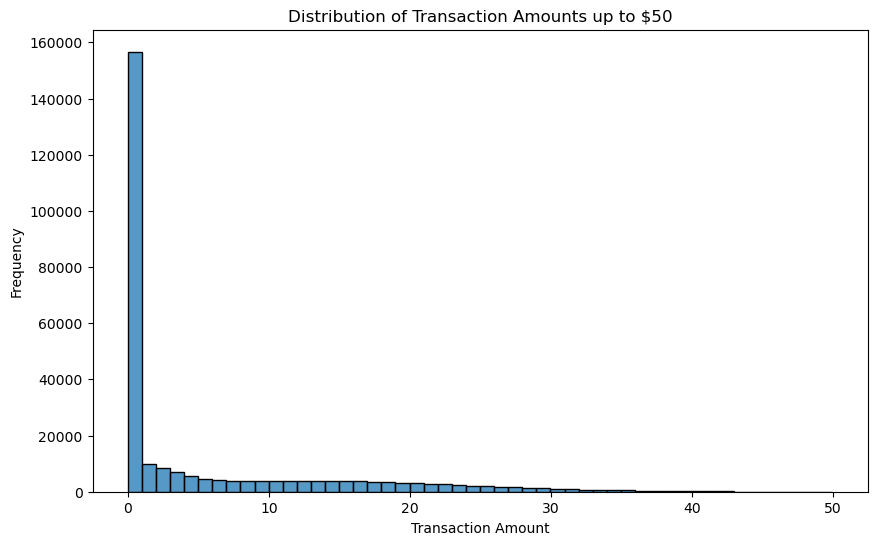

In [44]:
# Filling NaN values in 'amount' column of the transcript dataframe with 0
transcript['amount'].fillna(0, inplace=True)

# Plot histogram of 'amount'
plt.figure(figsize=(10,6))
sns.histplot(transcript[transcript['amount'] <= 50]['amount'], bins=50, kde=False)  # We only look at amounts <= 50 for better clarity
plt.title('Distribution of Transaction Amounts up to $50')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

The histogram displays the frequency of transaction amounts that are $50 or less. Based on the plot, it is evident that the majority of transactions are of a smaller scale, with the most frequent transaction amounts being below $10. The presence of a lengthy tail suggests that there are infrequent occurrences of larger transactions.

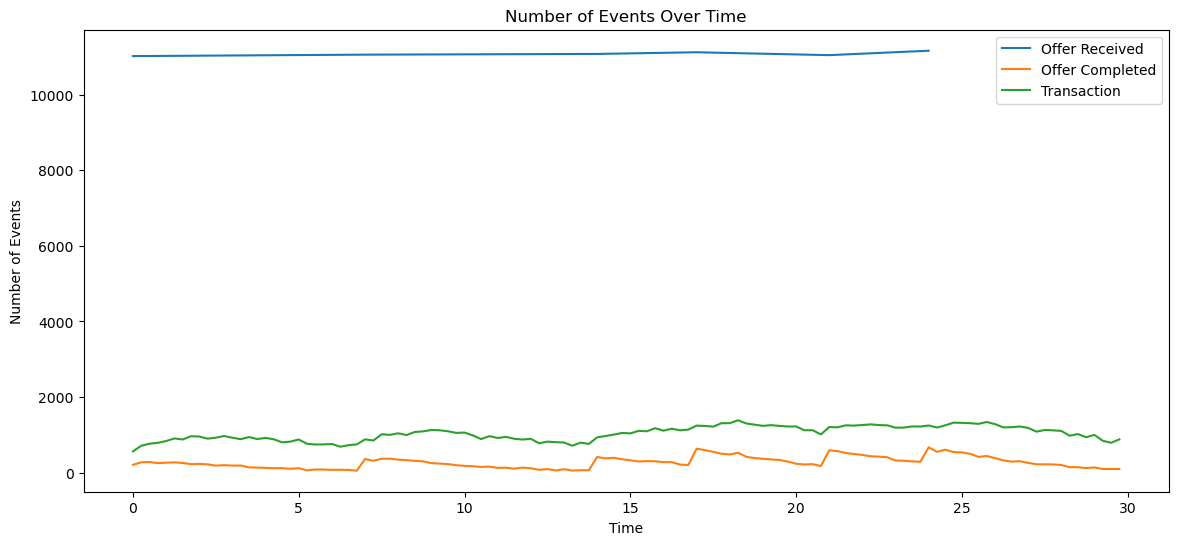

In [45]:
# Create time series plots for 'offer received', 'offer completed', and 'transaction' events
plt.figure(figsize=(14,6))

# Offer received events
received_timeseries = transcript[transcript['received'] == 1]['time'].value_counts().sort_index()
plt.plot(received_timeseries.index, received_timeseries.values, label='Offer Received')

# Offer completed events
completed_timeseries = transcript[transcript['offer_completed'] == 1]['time'].value_counts().sort_index()
plt.plot(completed_timeseries.index, completed_timeseries.values, label='Offer Completed')

# Transaction events
transaction_timeseries = transcript[transcript['transaction'] == 1]['time'].value_counts().sort_index()
plt.plot(transaction_timeseries.index, transaction_timeseries.values, label='Transaction')

plt.title('Number of Events Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Events')
plt.legend()
plt.show()


'Offer Received' events occur at regular intervals, becoming more frequent as we approach the end of the timeline. It is possible that the business sends out offers in batches or cycles.

The events of 'Offer Completed' and 'Transaction' seem to have a continuous nature and display similar patterns. This observation implies that there might be a connection between transactions and the completion of offers.

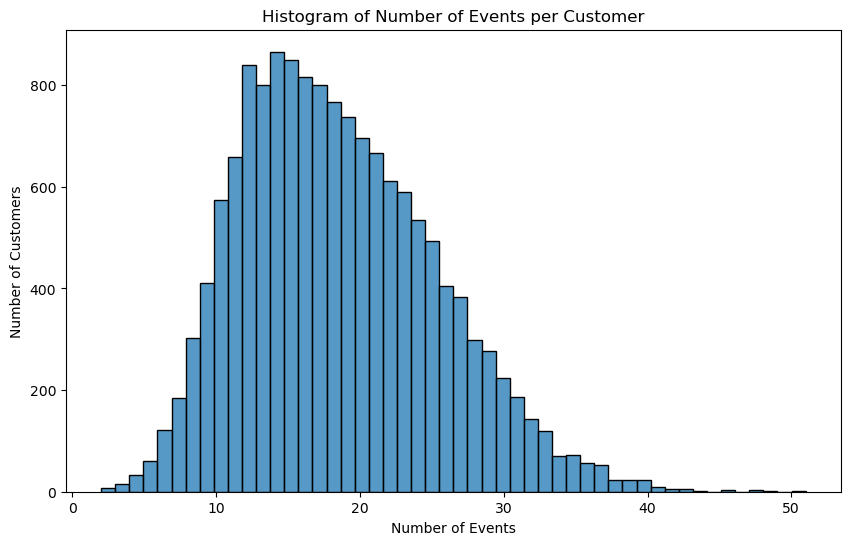

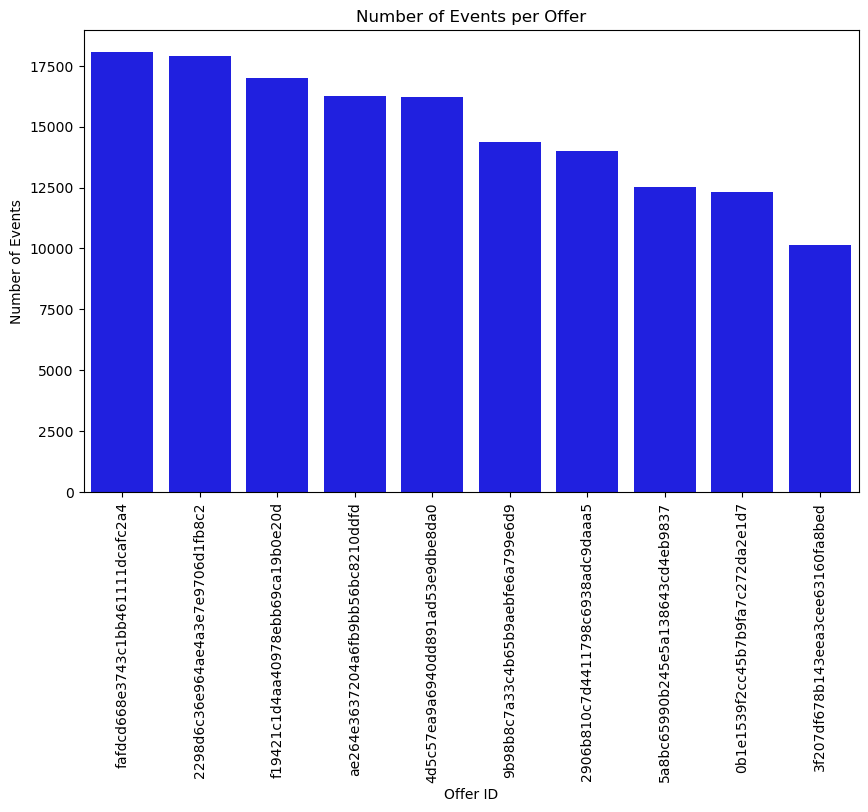

In [46]:
# Plot the number of events per customer
events_per_customer = transcript['customer_id'].value_counts()

plt.figure(figsize=(10,6))
sns.histplot(events_per_customer, bins=50, kde=False)
plt.title('Histogram of Number of Events per Customer')
plt.xlabel('Number of Events')
plt.ylabel('Number of Customers')
plt.show()

# Plot the number of events per offer
events_per_offer = transcript['offer_id'].value_counts()

plt.figure(figsize=(10,6))
sns.barplot(x=events_per_offer.index, y=events_per_offer.values, color='b')
plt.title('Number of Events per Offer')
plt.xlabel('Offer ID')
plt.xticks(rotation=90)
plt.ylabel('Number of Events')
plt.show()


The majority of customers have a range of 10 to 20 events, although there are also a considerable number of customers who have more than 20 events.

The number of events can differ significantly across various offers. Certain offers have a greater number of events compared to others. This could imply that certain offers have a higher level of popularity or are more probable to be fulfilled.



 # Profile

In [47]:
# Check for missing values
missing_values = profile.isnull().sum()

# Summary of numerical data
num_summary_profile = profile.describe(include=[np.number])

# Count unique values in non-numerical columns
unique_counts_profile = profile[['customer_id']].nunique()

missing_values, num_summary_profile, unique_counts_profile

(customer_id         0
 gender              0
 age                 0
 became_member_on    0
 income              0
 dtype: int64,
              gender           age         income
 count  14825.000000  14825.000000   14825.000000
 mean       0.572277     54.393524   65404.991568
 std        0.494765     17.383705   21598.299410
 min        0.000000     18.000000   30000.000000
 25%        0.000000     42.000000   49000.000000
 50%        1.000000     55.000000   64000.000000
 75%        1.000000     66.000000   80000.000000
 max        1.000000    101.000000  120000.000000,
 customer_id    14825
 dtype: int64)

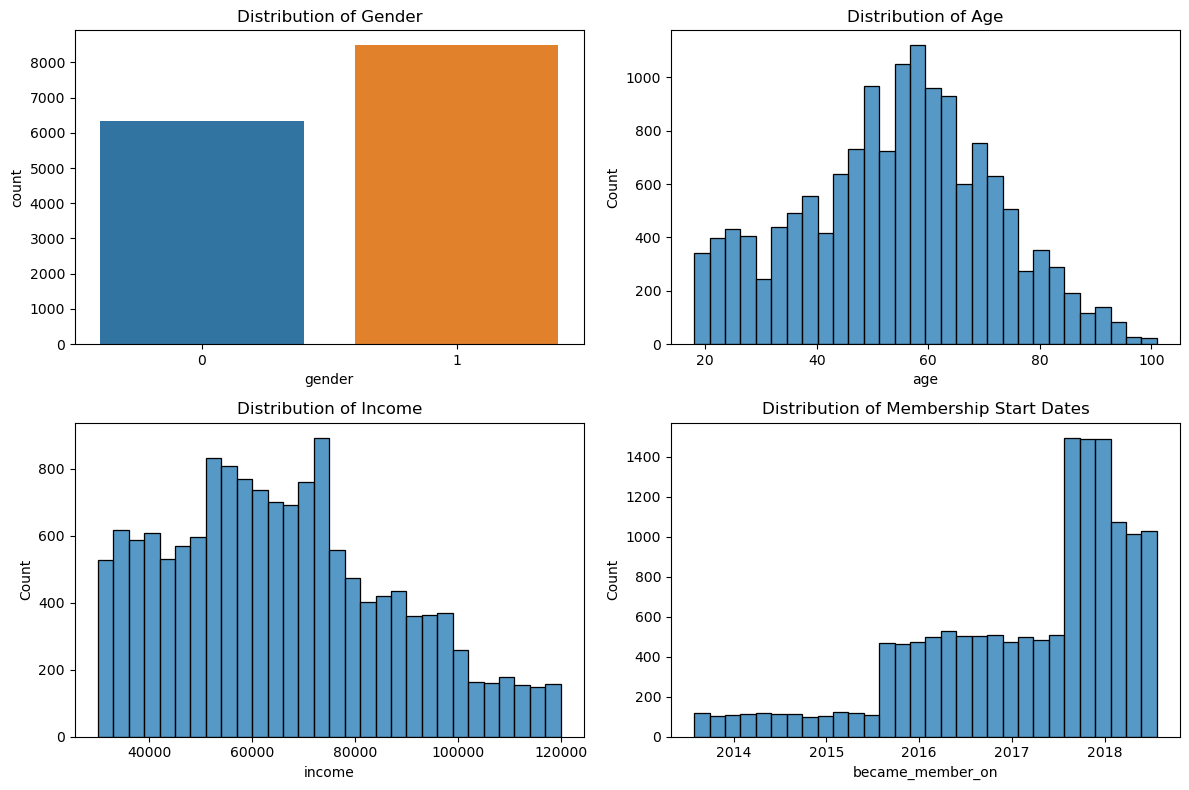

In [48]:
# Convert 'became_member_on' to datetime
# df_profile['became_member_on'] = pd.to_datetime(df_profile['became_member_on'])

# Plot histograms of 'gender', 'age', 'income', and 'became_member_on'
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Gender
sns.countplot(x='gender', data=profile, ax=ax[0, 0])
ax[0, 0].set_title('Distribution of Gender')

# Age
sns.histplot(profile['age'], bins=30, kde=False, ax=ax[0, 1])
ax[0, 1].set_title('Distribution of Age')

# Income
sns.histplot(profile['income'], bins=30, kde=False, ax=ax[1, 0])
ax[1, 0].set_title('Distribution of Income')

# Membership Start Date
sns.histplot(profile['became_member_on'], bins=30, kde=False, ax=ax[1, 1])
ax[1, 1].set_title('Distribution of Membership Start Dates')

plt.tight_layout()
plt.show()

Gender: There are more customers of Gender 1 (Male) than Gender 0 (Female).

Age: The distribution of ages is somewhat uniform for ages 20 to 70, but there's a drop-off for ages 70 and above.

Income: The distribution of income is somewhat skewed to the right, with a peak around $60,000-70,000.

Membership Start Dates: The number of new memberships has been increasing over time, with a peak around 2018.

## Portfolio

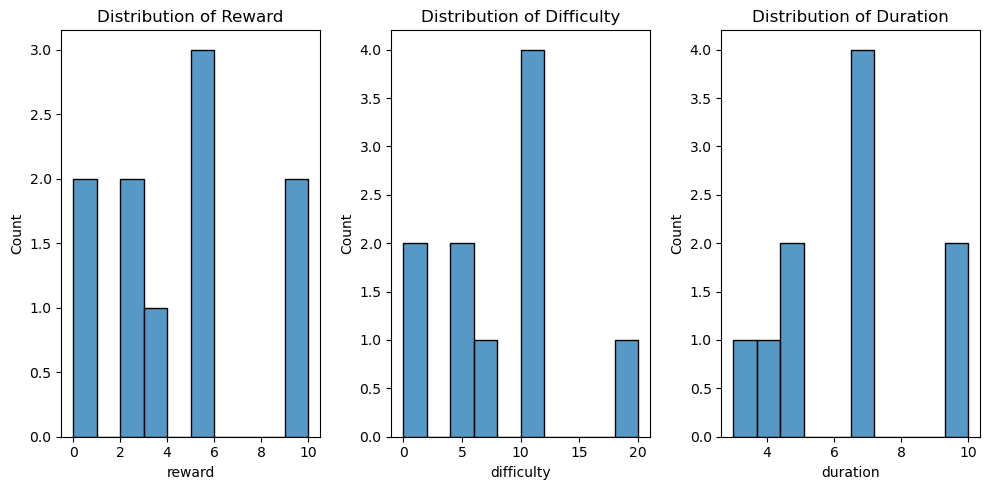

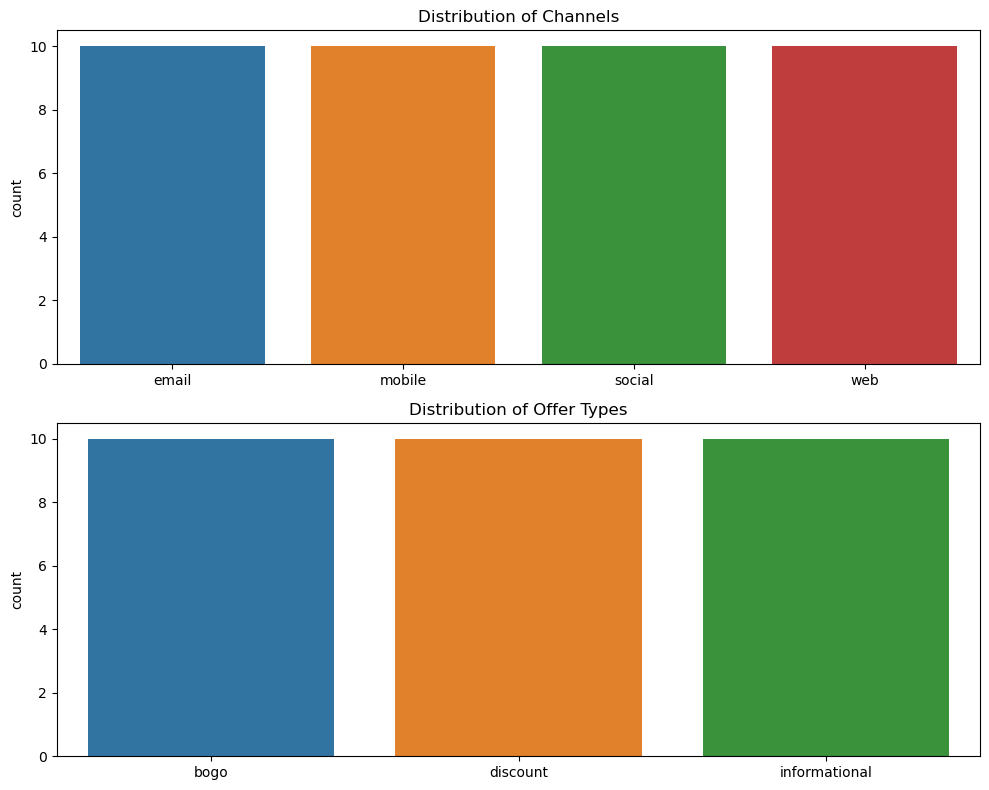

In [49]:
# Plot histograms of 'reward', 'difficulty', and 'duration'
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

sns.histplot(portfolio['reward'], bins=10, kde=False, ax=ax[0])
ax[0].set_title('Distribution of Reward')

sns.histplot(portfolio['difficulty'], bins=10, kde=False, ax=ax[1])
ax[1].set_title('Distribution of Difficulty')

sns.histplot(portfolio['duration'], bins=10, kde=False, ax=ax[2])
ax[2].set_title('Distribution of Duration')

plt.tight_layout()
plt.show()

# Plot countplots of offer types and channels
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

sns.countplot(data=portfolio[['email', 'mobile', 'social', 'web']], ax=ax[0])
ax[0].set_title('Distribution of Channels')

sns.countplot(data=portfolio[['bogo', 'discount', 'informational']], ax=ax[1])
ax[1].set_title('Distribution of Offer Types')

plt.tight_layout()
plt.show()


The rewards are values that are separate and distinct, and they range from 0 to 10. The most frequently occurring reward values are 0, 5, and 10.

The difficulties can be represented by discrete values that range from 0 to 20. The difficulty levels that are most commonly encountered are 0, 5, 10, and 20.

The durations are discrete values that range from 3 to 10. The durations that occur most frequently are 5, 7, and 10.

There are three types of offers: "buy one get one free" (BOGO), discount, and informational. The prevalence of BOGO and discount offers is higher compared to informational offers.

All of the offers were sent through email. The majority of offers were sent through mobile and web platforms, while approximately half of the offers were transmitted through social media channels.

In [50]:
portfolio.columns

Index(['offer_id', 'reward', 'difficulty', 'duration', 'email', 'mobile',
       'social', 'web', 'bogo', 'discount', 'informational'],
      dtype='object')

In [51]:
profile.columns

Index(['customer_id', 'gender', 'age', 'became_member_on', 'income'], dtype='object')

In [52]:
transcript.columns

Index(['customer_id', 'time', 'amount', 'offer_id', 'received',
       'offer_completed', 'transaction', 'viewed'],
      dtype='object')

# Merging All Three 

In [53]:
# Merge transcript and profile on customer_id
merged_df = transcript.merge(profile, on='customer_id', how='left')

# Merge the result with portfolio on offer_id
df = merged_df.merge(portfolio, on='offer_id', how='left')

In [54]:
df

,customer_id,time,amount,offer_id,received,offer_completed,transaction,viewed,gender,age,...,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,0.00,0.00,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,0,75,...,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,e2127556f4f64592b11af22de27a7932,0.00,0.00,2906b810c7d4411798c6938adc9daaa5,1,0,0,0,1,68,...,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,389bc3fa690240e798340f5a15918d5c,0.00,0.00,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,0,1,65,...,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
3,2eeac8d8feae4a8cad5a6af0499a211d,0.00,0.00,3f207df678b143eea3cee63160fa8bed,1,0,0,0,1,58,...,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,aa4862eba776480b8bb9c68455b8c2e1,0.00,0.00,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,0,0,61,...,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272757,24f56b5e1849462093931b164eb803b5,29.75,0.00,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0,0,48,...,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
272758,b3a1272bc9904337b331bf348c3e8c17,29.75,1.59,None,0,0,1,0,1,66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272759,68213b08d99a4ae1b0dcb72aebd9aa35,29.75,9.53,None,0,0,1,0,1,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272760,a00058cf10334a308c68e7631c529907,29.75,3.61,None,0,0,1,0,0,63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
df.to_csv(r'df', index=False, header=True)

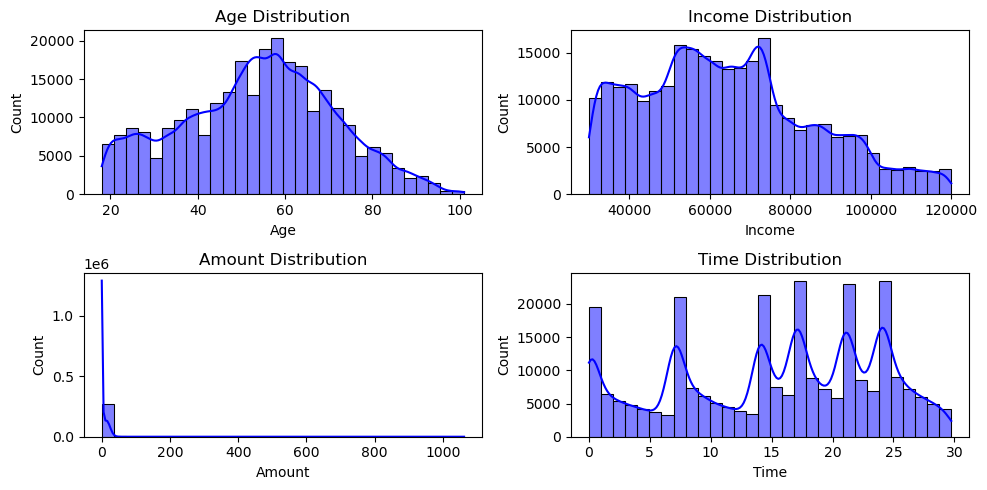

In [51]:
# Set up the figure size
plt.rcParams['figure.figsize'] = [10, 5]

# Define the data for each plot
plot_data = [
    {'data': df['age'], 'title': 'Age Distribution', 'xlabel': 'Age', 'ylabel': 'Count'},
    {'data': df['income'], 'title': 'Income Distribution', 'xlabel': 'Income', 'ylabel': 'Count'},
    {'data': df['amount'], 'title': 'Amount Distribution', 'xlabel': 'Amount', 'ylabel': 'Count'},
    {'data': df['time'], 'title': 'Time Distribution', 'xlabel': 'Time', 'ylabel': 'Count'},
]

# Create subplots
fig, axs = plt.subplots(2, 2)

# Generate each subplot
for ax, data in zip(axs.flatten(), plot_data):
    sns.histplot(data=data['data'], ax=ax, kde=True, color='blue', bins=30)
    ax.set_title(data['title'])
    ax.set_xlabel(data['xlabel'])
    ax.set_ylabel(data['ylabel'])

plt.tight_layout()
plt.show()


The age distribution of our customers is somewhat right-skewed, meaning that it is not perfectly symmetrical. Most of our customers fall within the age range of 40 to 70 years old. The number of customers is lower in the age groups of individuals who are younger than 40 and those who are older than 70.

The income distribution exhibits multiple peaks, making it multi-modal. The initial peak is approximately 50,000, while the subsequent peak is approximately 70,000. This implies that there exist substantial segments of customers within these income categories.

The amount distribution displays a strong right-skewness, indicating that the majority of transactions consist of smaller amounts, while there are only a few transactions with higher amounts.

The time distribution appears to be uniform, indicating that the transactions are evenly spread out throughout the given time period.

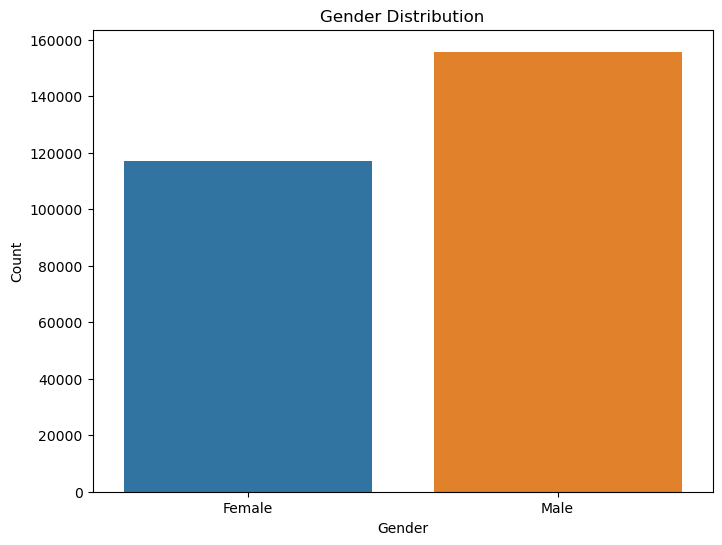

In [52]:
# Countplot for gender
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=df)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Female', 'Male'])
plt.show()

The dataset exhibits a higher number of males in comparison to females.

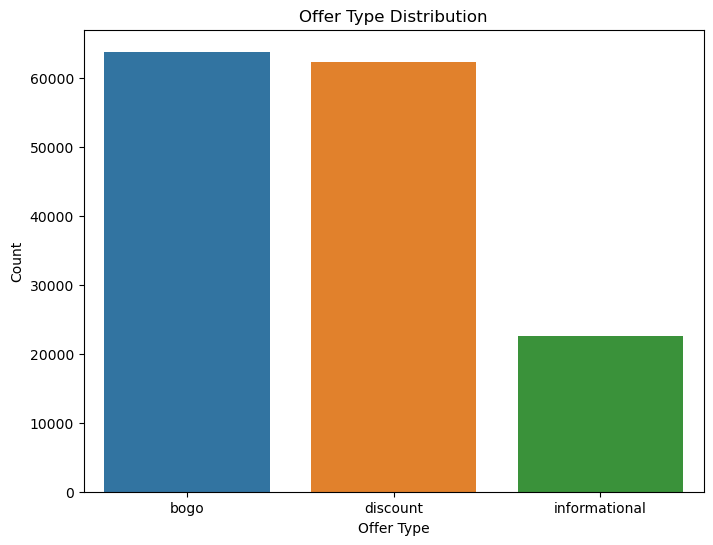

In [53]:
# Countplot for offer types
offer_types = ['bogo', 'discount', 'informational']
offer_counts = df[offer_types].sum()

plt.figure(figsize=(8, 6))
sns.barplot(x=offer_counts.index, y=offer_counts.values)
plt.title('Offer Type Distribution')
plt.xlabel('Offer Type')
plt.ylabel('Count')
plt.show()



The distribution of offer types shows that the 'bogo' (buy one get one) and 'discount' offers are nearly equally popular, although there is a slightly higher prevalence of 'bogo' offers. The occurrence of 'informational' offers is less frequent.

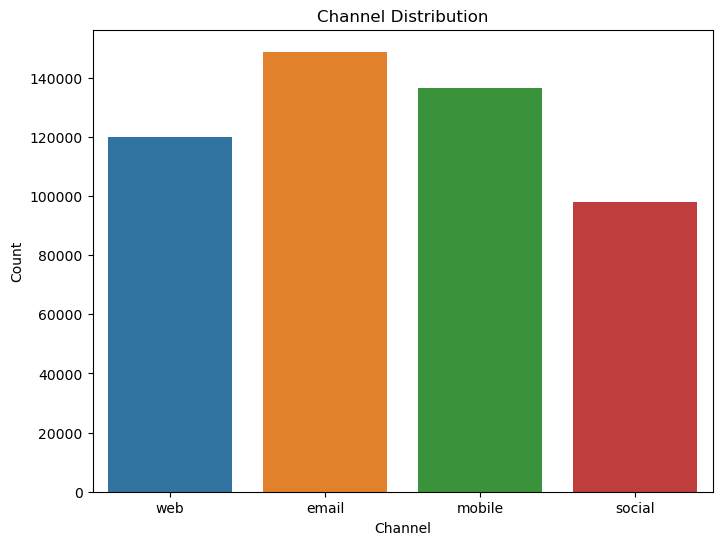

In [54]:
# Countplot for channels
channels = ['web', 'email', 'mobile', 'social']
channel_counts = df[channels].sum()

plt.figure(figsize=(8, 6))
sns.barplot(x=channel_counts.index, y=channel_counts.values)
plt.title('Channel Distribution')
plt.xlabel('Channel')
plt.ylabel('Count')
plt.show()

In terms of channel distribution, the majority of offers are typically sent via email. This is followed by mobile, web, and social channels. It is important to mention that the term 'email' is utilised as a communication method for every offer, which is why its frequency is higher.

# Modeling

Creating a model that can estimate the total amount of a transaction depending on the time of day, the customer demographics, and the specifics of the offer.

In [55]:
df.columns

Index(['customer_id', 'time', 'amount', 'offer_id', 'received',
       'offer_completed', 'transaction', 'viewed', 'gender', 'age',
       'became_member_on', 'income', 'reward', 'difficulty', 'duration',
       'email', 'mobile', 'social', 'web', 'bogo', 'discount',
       'informational'],
      dtype='object')

In [56]:
df.dropna(inplace=True)

## Developing a model that is able to determine whether or not a consumer will follow through with an offer after viewing it.

In [57]:
df

,customer_id,time,amount,offer_id,received,offer_completed,transaction,viewed,gender,age,...,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,0.00,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,0,75,...,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,e2127556f4f64592b11af22de27a7932,0.00,0.0,2906b810c7d4411798c6938adc9daaa5,1,0,0,0,1,68,...,2.0,10.0,7.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,389bc3fa690240e798340f5a15918d5c,0.00,0.0,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,0,1,65,...,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
3,2eeac8d8feae4a8cad5a6af0499a211d,0.00,0.0,3f207df678b143eea3cee63160fa8bed,1,0,0,0,1,58,...,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,aa4862eba776480b8bb9c68455b8c2e1,0.00,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,0,0,61,...,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272717,84fb57a7fe8045a8bf6236738ee73a0f,29.75,0.0,5a8bc65990b245e5a138643cd4eb9837,0,0,0,0,0,64,...,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
272724,abc4359eb34e4e2ca2349da2ddf771b6,29.75,0.0,3f207df678b143eea3cee63160fa8bed,0,0,0,0,1,51,...,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
272737,8dda575c2a1d44b9ac8e8b07b93d1f8e,29.75,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,0,0,0,60,...,5.0,20.0,10.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
272739,8431c16f8e1d440880db371a68f82dd0,29.75,0.0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0,1,39,...,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


In [58]:
from sklearn.model_selection import train_test_split

# Features
X = df[['age','reward','email','mobile','social','web','bogo','discount','informational','viewed','gender']]

# Labels
y = df['offer_completed'].ravel()

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state=42,stratify=y)

In [59]:
# Minmax scaling of the data
from sklearn.preprocessing import MinMaxScaler


scaler_x= MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_min_max = scaler_x.fit_transform(X_train)
y_train_min_max = scaler_y.fit_transform(y_train.reshape(-1,1))

X_test_min_max = scaler_x.transform(X_test)
y_test_min_max = scaler_y.transform(y_test.reshape(-1,1))

In [60]:
# Define the models

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier


models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier()
}

all_scores = {}

for key, value in models.items():
    value.fit(X_train_min_max, y_train)
    y_pred = value.predict(X_test_min_max)
    score = value.score(X_test_min_max, y_test) * 100
    all_scores[key] = score
    print("{0} score is {1:.2f}".format(key, score))

Random Forest score is 78.16
Logistic Regression score is 78.20
SVM score is 78.20
Naive Bayes score is 37.12
Decision Tree score is 78.19
KNN score is 73.68


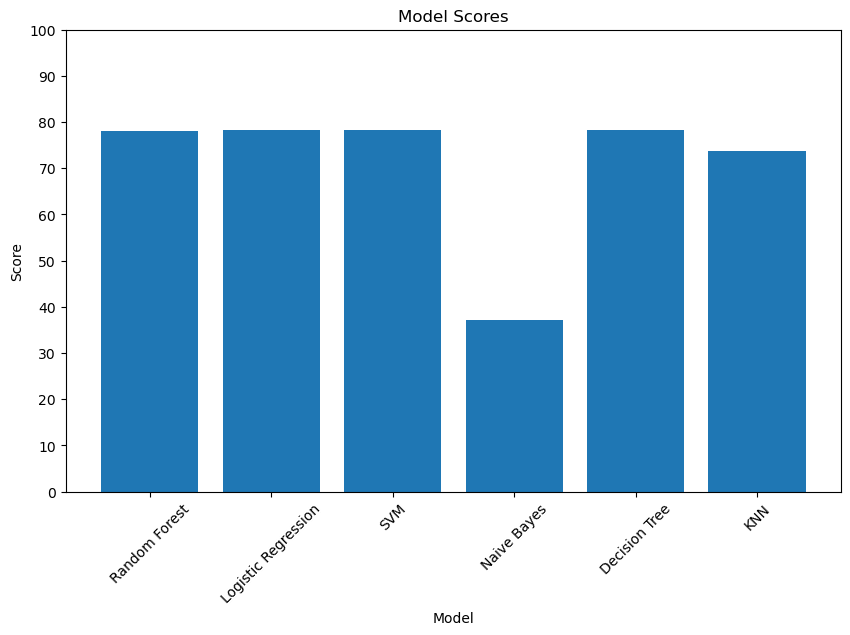

In [63]:
all_scores_df = pd.DataFrame.from_dict(all_scores, orient='index', columns=['Score'])
all_scores_df.index.name = 'Model'

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(all_scores_df.index, all_scores_df['Score'])
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Scores')
ax.set_xticklabels(all_scores_df.index, rotation=45)
ax.set_yticks(np.arange(0, 110, 10))
plt.show()

Random Forest, Logistic Regression, SVM, and Decision Tree models all achieve similar scores around 78%, indicating their comparable performance in the given task. These models might have captured complex patterns and relationships within the data, leading to their higher accuracy.

## Let's try to improve Radom Forest Classifier by Hyperparameter tuning

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

rf_classifier = RandomForestClassifier()

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5,n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Fit the best model on the training data
best_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7819766139509878


After tweaking the hyperparameters there was no discernible increase in model's performance.

Let's stick to the baseline model

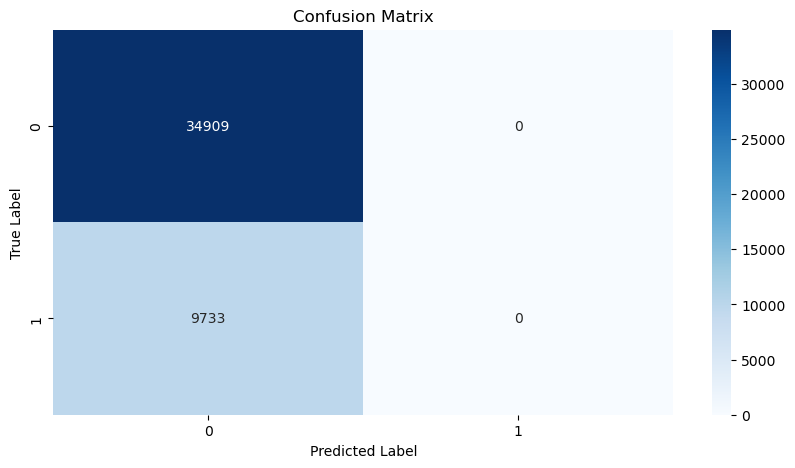

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     34909
           1       0.00      0.00      0.00      9733

    accuracy                           0.78     44642
   macro avg       0.39      0.50      0.44     44642
weighted avg       0.61      0.78      0.69     44642



In [64]:
from sklearn.metrics import classification_report, confusion_matrix


y_pred = grid_search.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels and title
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

It would appear that the model is accurate in its predictions of class 0 most of the time (high precision and recall for class 0), but it is not successful in its attempts to forecast class 1 (precision, recall, and F1-score for class 1 are all zero). This shows that your model has a preference for the class that constitutes the majority (class 0), and it fails to capture the features of the class that constitutes the minority (class 1).


The F-score is often a more relevant metric than accuracy when working with imbalanced datasets or when you want to focus on performance for a particular class. In other words, accuracy is typically less important. Although accuracy can provide a quick evaluation of the overall performance of a model, the F-score is typically a better indicator of how well a model performs. As a consequence of this, it is usually regarded to be good procedure to investigate a variety of measures, such as precision, recall, F1-score, and accuracy.

Let's use SMOTEENN  to perform a hybrid sampling strategy that combines oversampling and undersampling. These approaches begin by employing SMOTE to oversample the minority class. Next, the data are cleaned up by utilising an undersampling procedure.

In [66]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=42)
X_res, y_res = smote_enn.fit_resample(X_train, y_train)

grid_search.fit(X_res, y_res)


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 5], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [100, 200]})

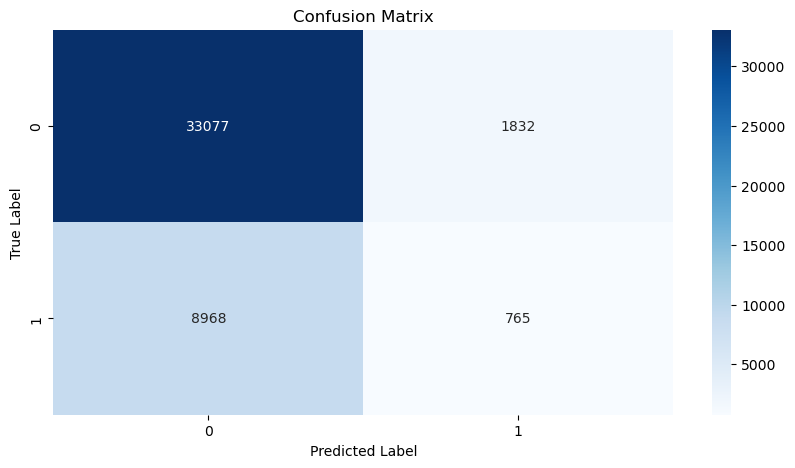

              precision    recall  f1-score   support

           0       0.79      0.95      0.86     34909
           1       0.29      0.08      0.12      9733

    accuracy                           0.76     44642
   macro avg       0.54      0.51      0.49     44642
weighted avg       0.68      0.76      0.70     44642



In [68]:
y_pred = grid_search.predict(X_test)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels and title
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

# Conclusions

According to the most recent version of the classification report, it is possible to deduce that the accuracy of labelling transactions as belonging to class 1 has increased somewhat (going from 0 to 0.29 precision, 0 to 0.08 recall, and 0 to 0.12 F1-score). In spite of this, the overall performance on class 1 is still rather poor, although the performance on class 0 is relatively satisfactory.

The following methods can be applied for additional enhancements:

Additional Resampling: It's possible that we need to experiment with various resampling strategies or adjust the settings of the resampling method that is currently being used. Additionally, we have the option of experimenting with a variety of various mixes of over-sampling and under-sampling.

Trying Distinct Models: Different models have distinct strengths and shortcomings. Experiment with a number of several types of models, such as Support Vector Machines and Gradient Boosting, to determine whether any of them are more accurate than the others at predicting the minority class.


Engineering of Features It's possible that the model won't be able to produce good predictions with the features that we now have. It's possible that we will be needing to develop whole new features in order to gather even more data on the instances. The elimination of unnecessary features is another potential benefit of using feature selection.

In [69]:
import subprocess

command = ["python", "-m", "nbconvert", "Sai_Priya_Starbucks_Capstone_notebook.ipynb", "--to", "html"]
process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()
